# Model Performance Analysis

This notebook evaluates and compares the performance of the different LLM prediction models, both with and without PPO adjustments.

## 1. Import Libraries

In [107]:
import pandas as pd
import numpy as np
import json

def load_jsonl(filepath):
    """Load JSONL file"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def parse_prompt_data(prompt_text):
    """Extract key information from prompt"""
    lines = prompt_text.split('\n')
    data = {}
    
    for line in lines:
        if 'TICKER:' in line:
            data['ticker'] = line.split('TICKER:')[1].strip()
        elif 'DATE:' in line:
            data['date'] = line.split('DATE:')[1].strip()
        elif 'RECENT CLOSING PRICES' in line:
            if ':' in line:
                prices_part = line.split(':', 1)[1].strip()
                if '(' in prices_part:
                    prices_part = prices_part.split('(')[0].strip()
                try:
                    data['recent_prices'] = [float(p.strip()) for p in prices_part.split(',') if p.strip()]
                except (ValueError, AttributeError): # Handle cases where prices are not valid
                    data['recent_prices'] = []
    
    return data

print("Libraries and helper functions imported.")

Libraries and helper functions imported.


## 2. Load Prediction Data

In [108]:
try:
    # --- Load PPO-adjusted predictions ---
    # Original PPO model
    inference_ppo_df = pd.read_csv('../results/test_predictions_with_ppo.csv')
    # Optimized PPO model (Paper's Method)
    paper_ppo_df = pd.read_csv('../results/test_predictions_with_ppo_optimized.csv')

    # --- Load raw LLM predictions (without PPO) ---
    with open('../results/llm_predictions_checkpoint.json', 'r') as f:
        inference_raw = json.load(f)
    with open('../results/llm_predictions_justification_checkpoint.json', 'r') as f:
        justification_raw = json.load(f)
    with open('../results/llm_predictions_cot_checkpoint.json', 'r') as f:
        cot_raw = json.load(f)
    
    # --- Load RNN/LSTM predictions ---
    rnn_lstm_df = pd.read_csv('../results/rnn_lstm_predictions.csv')
    rnn_lstm_df['date'] = pd.to_datetime(rnn_lstm_df['date'])
        
    print("All prediction files loaded successfully.")
    print(f"RNN/LSTM predictions shape: {rnn_lstm_df.shape}")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure all inference notebooks have been run.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

All prediction files loaded successfully.
RNN/LSTM predictions shape: (2477, 6)


## 3. Calculate and Compare MAE

In [109]:
def calculate_mae_from_df(df, pred_col, actual_col='actual_price'):
    """Calculates the Mean Absolute Error from a DataFrame."""
    return np.mean(np.abs(df[pred_col] - df[actual_col]))

def calculate_mae_from_raw(raw_data):
    """Calculates the Mean Absolute Error from raw checkpoint data, handling None values."""
    valid_predictions = []
    valid_actuals = []
    
    llm_results = raw_data.get('llm_results', [])
    actual_prices = raw_data.get('actual_prices', [])
    
    num_samples = min(len(llm_results), len(actual_prices))

    for i in range(num_samples):
        prediction = llm_results[i].get('predicted_close')
        actual = actual_prices[i]
        
        if prediction is not None:
            valid_predictions.append(float(prediction))
            valid_actuals.append(float(actual))
            
    if not valid_predictions:
        return np.nan

    return np.mean(np.abs(np.array(valid_predictions) - np.array(valid_actuals)))

results = {}

# RNN/LSTM models
if 'rnn_lstm_df' in locals():
    results['RNN'] = {'MAE': calculate_mae_from_df(rnn_lstm_df, 'rnn_prediction')}
    results['LSTM'] = {'MAE': calculate_mae_from_df(rnn_lstm_df, 'lstm_prediction')}

# PPO models
if 'inference_ppo_df' in locals():
    results['Inference (PPO Original)'] = {'MAE': calculate_mae_from_df(inference_ppo_df, 'ppo_adjusted_prediction')}
if 'paper_ppo_df' in locals():
    results['Inference (PPO Paper)'] = {'MAE': calculate_mae_from_df(paper_ppo_df, 'ppo_adjusted_prediction')}

# Raw LLM models
if 'inference_raw' in locals():
    results['Inference (LLM only)'] = {'MAE': calculate_mae_from_raw(inference_raw)}
if 'justification_raw' in locals():
    results['Justification (LLM only)'] = {'MAE': calculate_mae_from_raw(justification_raw)}
if 'cot_raw' in locals():
    results['CoT (LLM only)'] = {'MAE': calculate_mae_from_raw(cot_raw)}

if results:
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by='MAE', ascending=True)
    
    print("Model Performance Comparison (MAE):")
    display(results_df)
else:
    print("No data to compare. Please check the file loading step.")

Model Performance Comparison (MAE):


,MAE
Justification (LLM only),10.379693
CoT (LLM only),10.971941
RNN,27.099114
LSTM,33.837561
Inference (LLM only),62.115208
Inference (PPO Paper),62.391258
Inference (PPO Original),64.599908


## 4. Calculate and Compare MAPE

In [110]:
def calculate_mape_from_df(df, pred_col, actual_col='actual_price'):
    """Calculates the Mean Absolute Percentage Error from a DataFrame."""
    return np.mean(np.abs((df[actual_col] - df[pred_col]) / df[actual_col])) * 100

def calculate_mape_from_raw(raw_data):
    """Calculates the Mean Absolute Percentage Error from raw checkpoint data."""
    valid_predictions = []
    valid_actuals = []
    
    llm_results = raw_data.get('llm_results', [])
    actual_prices = raw_data.get('actual_prices', [])
    
    num_samples = min(len(llm_results), len(actual_prices))

    for i in range(num_samples):
        prediction = llm_results[i].get('predicted_close')
        actual = actual_prices[i]
        
        if prediction is not None and actual is not None and actual != 0:
            valid_predictions.append(float(prediction))
            valid_actuals.append(float(actual))
            
    if not valid_predictions:
        return np.nan

    return np.mean(np.abs((np.array(valid_actuals) - np.array(valid_predictions)) / np.array(valid_actuals))) * 100

mape_results = {}

# RNN/LSTM models
if 'rnn_lstm_df' in locals():
    mape_results['RNN'] = {'MAPE (%)': calculate_mape_from_df(rnn_lstm_df, 'rnn_prediction')}
    mape_results['LSTM'] = {'MAPE (%)': calculate_mape_from_df(rnn_lstm_df, 'lstm_prediction')}

# PPO models
if 'inference_ppo_df' in locals():
    mape_results['Inference (PPO Original)'] = {'MAPE (%)': calculate_mape_from_df(inference_ppo_df, 'ppo_adjusted_prediction')}
if 'paper_ppo_df' in locals():
    mape_results['Inference (PPO Paper)'] = {'MAPE (%)': calculate_mape_from_df(paper_ppo_df, 'ppo_adjusted_prediction')}

# Raw LLM models
if 'inference_raw' in locals():
    mape_results['Inference (LLM only)'] = {'MAPE (%)': calculate_mape_from_raw(inference_raw)}
if 'justification_raw' in locals():
    mape_results['Justification (LLM only)'] = {'MAPE (%)': calculate_mape_from_raw(justification_raw)}
if 'cot_raw' in locals():
    mape_results['CoT (LLM only)'] = {'MAPE (%)': calculate_mape_from_raw(cot_raw)}

if mape_results:
    mape_df = pd.DataFrame(mape_results).T
    mape_df = mape_df.sort_values(by='MAPE (%)', ascending=True)
    
    print("Model Performance Comparison (MAPE %):")
    display(mape_df)
else:
    print("No data to compare. Please check the file loading step.")

Model Performance Comparison (MAPE %):


,MAPE (%)
Justification (LLM only),1.329401
CoT (LLM only),1.365380
RNN,4.763616
LSTM,6.345277
Inference (LLM only),6.789956
Inference (PPO Paper),6.886098
Inference (PPO Original),7.320734


## 5. Segmented Performance Analysis (by Volatility)

Segmented Performance by Market Volatility (MAPE %):


,MAPE (%)
RNN (High Vol),5.054897
RNN (Low Vol),4.472569
LSTM (High Vol),6.119108
LSTM (Low Vol),6.571263
Inference (PPO Paper) (High Vol),10.496539
Inference (PPO Paper) (Low Vol),3.278572
Inference (LLM only) (High Vol),10.478713
Inference (LLM only) (Low Vol),3.104176
Justification (LLM only) (High Vol),1.466948
Justification (LLM only) (Low Vol),1.191965


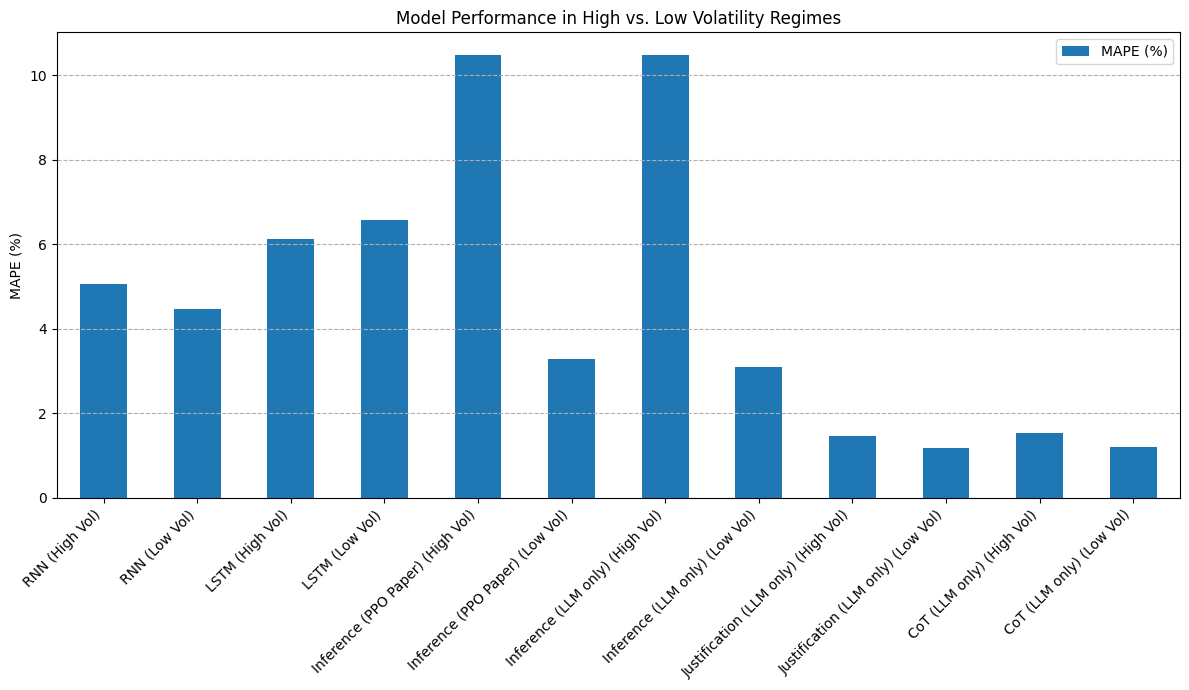

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast

def analyze_by_volatility(df, model_name, results_dict, pred_col='predicted_close'):
    """Calculates MAPE for high and low volatility regimes."""
    df['volatility'] = df['recent_prices'].apply(lambda x: np.std(np.diff(x) / x[:-1]) if (isinstance(x, list) and len(x) > 1) else 0)
    
    volatility_threshold = df['volatility'].median()

    if len(df['volatility'].unique()) == 1:
        results_dict[f'{model_name} (High Vol)'] = {'MAPE (%)': np.nan}
        results_dict[f'{model_name} (Low Vol)'] = {'MAPE (%)': calculate_mape_from_df(df, pred_col)}
        return

    high_vol_df = df[df['volatility'] > volatility_threshold]
    low_vol_df = df[df['volatility'] <= volatility_threshold]
    
    results_dict[f'{model_name} (High Vol)'] = {'MAPE (%)': calculate_mape_from_df(high_vol_df, pred_col)}
    results_dict[f'{model_name} (Low Vol)'] = {'MAPE (%)': calculate_mape_from_df(low_vol_df, pred_col)}

try:
    ground_truth_data = load_jsonl('../finetune_paper/test.jsonl')
    base_test_df = pd.DataFrame([parse_prompt_data(item['prompt']) for item in ground_truth_data])
except Exception as e:
    print(f"Could not load base data: {e}. Volatility analysis will be skipped.")
    base_test_df = None

volatility_results = {}

# --- Analyze RNN/LSTM Models ---
if 'rnn_lstm_df' in locals():
    # Make a copy to avoid modifying the original
    rnn_lstm_df_vol = rnn_lstm_df.copy()
    # Convert string representation of list to actual list if needed
    if isinstance(rnn_lstm_df_vol['recent_prices'].iloc[0], str):
        rnn_lstm_df_vol['recent_prices'] = rnn_lstm_df_vol['recent_prices'].apply(ast.literal_eval)
    analyze_by_volatility(rnn_lstm_df_vol, 'RNN', volatility_results, pred_col='rnn_prediction')
    
    rnn_lstm_df_vol = rnn_lstm_df.copy()
    if isinstance(rnn_lstm_df_vol['recent_prices'].iloc[0], str):
        rnn_lstm_df_vol['recent_prices'] = rnn_lstm_df_vol['recent_prices'].apply(ast.literal_eval)
    analyze_by_volatility(rnn_lstm_df_vol, 'LSTM', volatility_results, pred_col='lstm_prediction')

if base_test_df is not None:
    # --- Analyze PPO (Paper) Model ---
    if 'paper_ppo_df' in locals():
        # The CSV already has the necessary columns, just merge recent_prices
        paper_ppo_df['recent_prices'] = base_test_df['recent_prices']
        analyze_by_volatility(paper_ppo_df, 'Inference (PPO Paper)', volatility_results, pred_col='ppo_adjusted_prediction')

    # --- Analyze Inference (LLM only) Model ---
    if 'inference_raw' in locals():
        inference_df = pd.DataFrame(inference_raw['llm_results'])
        inference_df['actual_price'] = inference_raw['actual_prices']
        inference_df['recent_prices'] = base_test_df['recent_prices']
        analyze_by_volatility(inference_df, 'Inference (LLM only)', volatility_results)

    # --- Analyze Justification Model ---
    if 'justification_raw' in locals():
        justification_df = pd.DataFrame(justification_raw['llm_results'])
        justification_df['actual_price'] = justification_raw['actual_prices']
        justification_df['recent_prices'] = base_test_df['recent_prices']
        analyze_by_volatility(justification_df, 'Justification (LLM only)', volatility_results)

    # --- Analyze CoT Model ---
    if 'cot_raw' in locals():
        cot_df = pd.DataFrame(cot_raw['llm_results'])
        cot_df['actual_price'] = cot_raw['actual_prices']
        cot_df['recent_prices'] = base_test_df['recent_prices']
        analyze_by_volatility(cot_df, 'CoT (LLM only)', volatility_results)

if volatility_results:
    volatility_df = pd.DataFrame(volatility_results).T
    
    print("Segmented Performance by Market Volatility (MAPE %):")
    display(volatility_df)
    
    volatility_df.plot(kind='bar', figsize=(12, 7))
    plt.title('Model Performance in High vs. Low Volatility Regimes')
    plt.ylabel('MAPE (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Could not perform volatility analysis. Data not available.")